In [1]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    X, feature_names, n_features, n_samples, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
with open('subsets.pickle', 'rb') as f:
    is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff = pickle.load(f)

In [3]:
try:
    with open('shapvalues.proba.pickle', 'rb') as f:
        shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, overall_importance, feature_order, shap_values_diff_a_vs_b_pos = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

No cached shap values found


## Generate Explanations

Now we define the difference functions to be explained:

In [4]:
merge_proba_diff_c1_pos = lambda p1, p2: p1[:, 1] * p2[:, 0]
predict_proba_diff_a_pos = lambda X: merge_proba_diff_c1_pos(clf_a.predict_proba(X), clf_b.predict_proba(X))
predict_proba_diff_b_pos = lambda X: merge_proba_diff_c1_pos(clf_b.predict_proba(X), clf_a.predict_proba(X))

In [5]:
merge_proba_diff = lambda p1, p2: merge_proba_diff_c1_pos(p1, p2) + merge_proba_diff_c1_pos(p2, p1)
predict_proba_diff = lambda X: merge_proba_diff(clf_a.predict_proba(X), clf_b.predict_proba(X))

And now we calculate SHAP values for each merge function:

In [6]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_diff_a_pos = explain(predict_proba_diff_a_pos)
shap_values_diff_b_pos = explain(predict_proba_diff_b_pos)

shap_values_diff = shap_values_diff_a_pos + shap_values_diff_b_pos
shap_values_diff.data = shap_values_diff_a_pos.data
shap_values_diff.display_data = shap_values_diff_a_pos.display_data

overall_importance = shap_values_diff.abs.mean(axis=0)
feature_order = np.flip(overall_importance.values.argsort())

shap_values_diff_a_vs_b_pos = shap_values_diff_b_pos - shap_values_diff_a_pos
shap_values_diff_a_vs_b_pos.data = shap_values_diff_a_pos.data

with open(f'shapvalues.proba.pickle', 'wb') as f:
    pickle.dump((shap_values_diff, shap_values_diff_a_pos, shap_values_diff_b_pos, overall_importance, feature_order, shap_values_diff_a_vs_b_pos), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 6.81 s, sys: 115 ms, total: 6.93 s
Wall time: 8.27 s


## Analyze

### Feature Importance

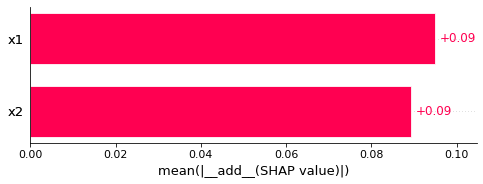

In [7]:
shap.plots.bar(overall_importance, max_display=n_features)

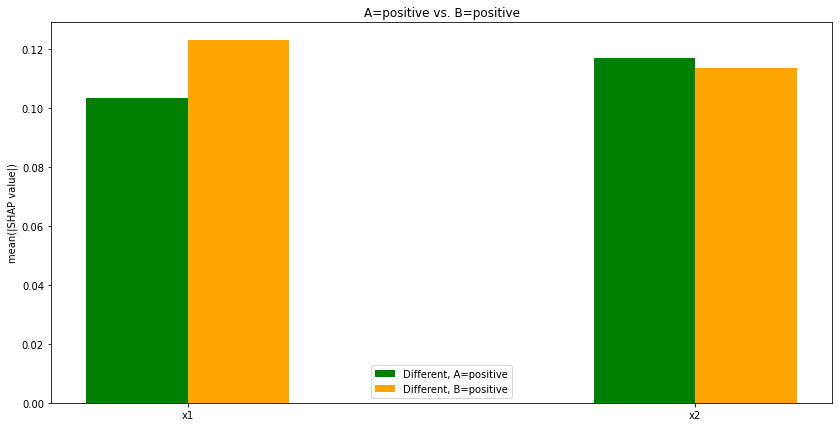

In [8]:
x = np.arange(n_features)
width = 0.2
fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, shap_values_diff_a_pos.abs.mean(0)[feature_order].values, width, label='Different, A=positive', color='green')
rects2 = ax.bar(x + width/2, shap_values_diff_b_pos.abs.mean(0)[feature_order].values, width, label='Different, B=positive', color='orange')
ax.set_ylabel('mean(|SHAP value|)')
ax.set_title('A=positive vs. B=positive')
ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.legend()
plt.show()

### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

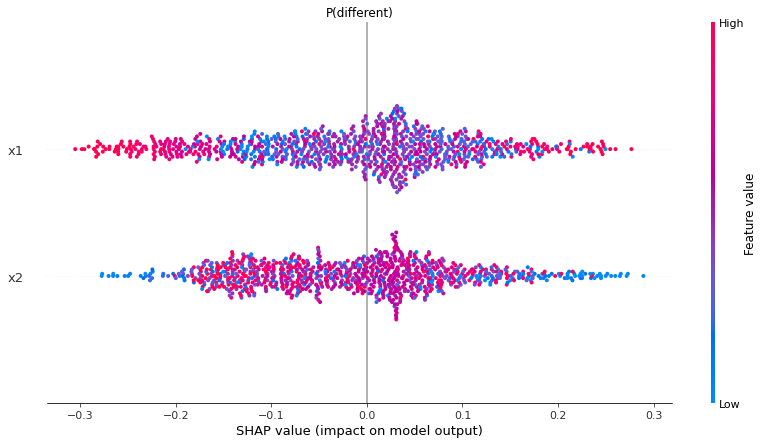

In [9]:
plot.shap_beeswarm(shap_values_diff, 'P(different)', order=feature_order, max_display=n_features)

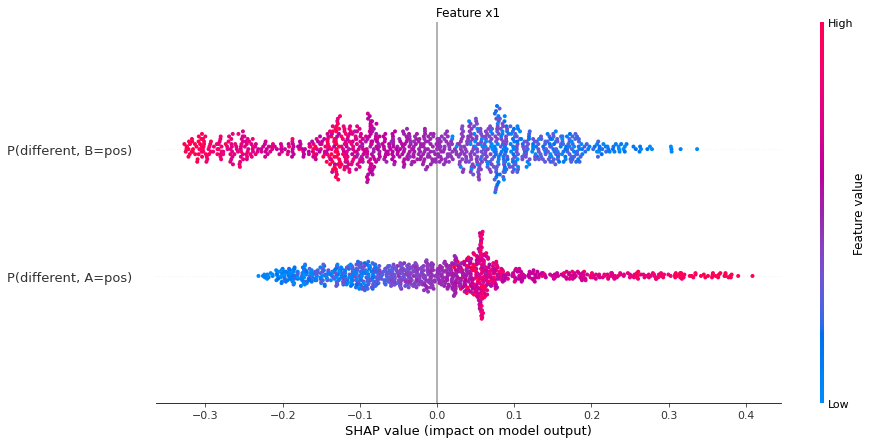

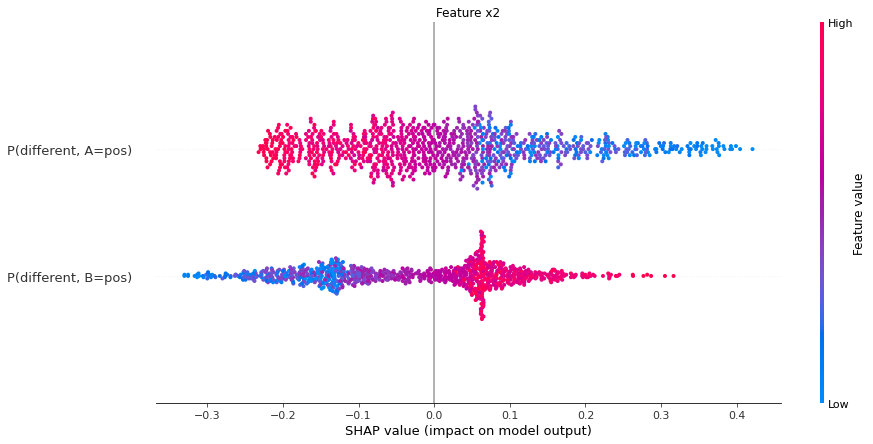

In [10]:
for feature in feature_names:
    a_feature = shap_values_diff_a_pos[:, feature]
    b_feature = shap_values_diff_b_pos[:, feature]
    values = np.array([a_feature.values, b_feature.values]).T
    base_values = np.array([a_feature.base_values, b_feature.base_values]).T
    data = np.array([a_feature.data, b_feature.data]).T
    display_data = np.array([a_feature.display_data, b_feature.display_data]).T
    explanation = shap.Explanation(values, base_values, data, display_data, feature_names=['P(different, A=pos)', 'P(different, B=pos)'])
    plot.shap_beeswarm(explanation, 'Feature ' + feature)

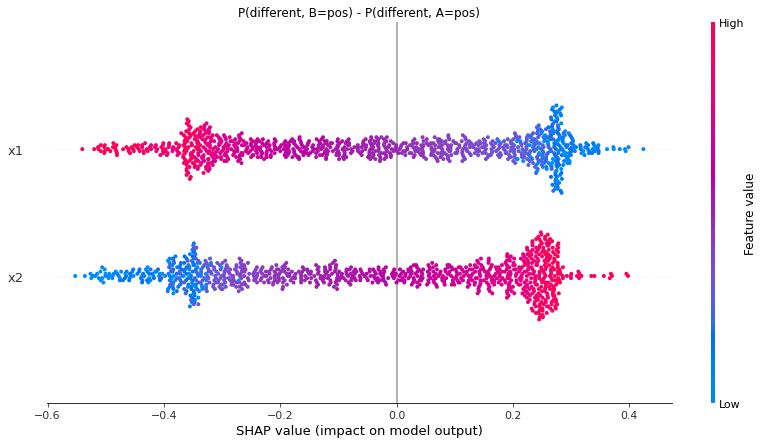

In [11]:
plot.shap_beeswarm(shap_values_diff_a_vs_b_pos, 'P(different, B=pos) - P(different, A=pos)', order=feature_order, max_display=n_features)

### Features' Partial Dependence Plots

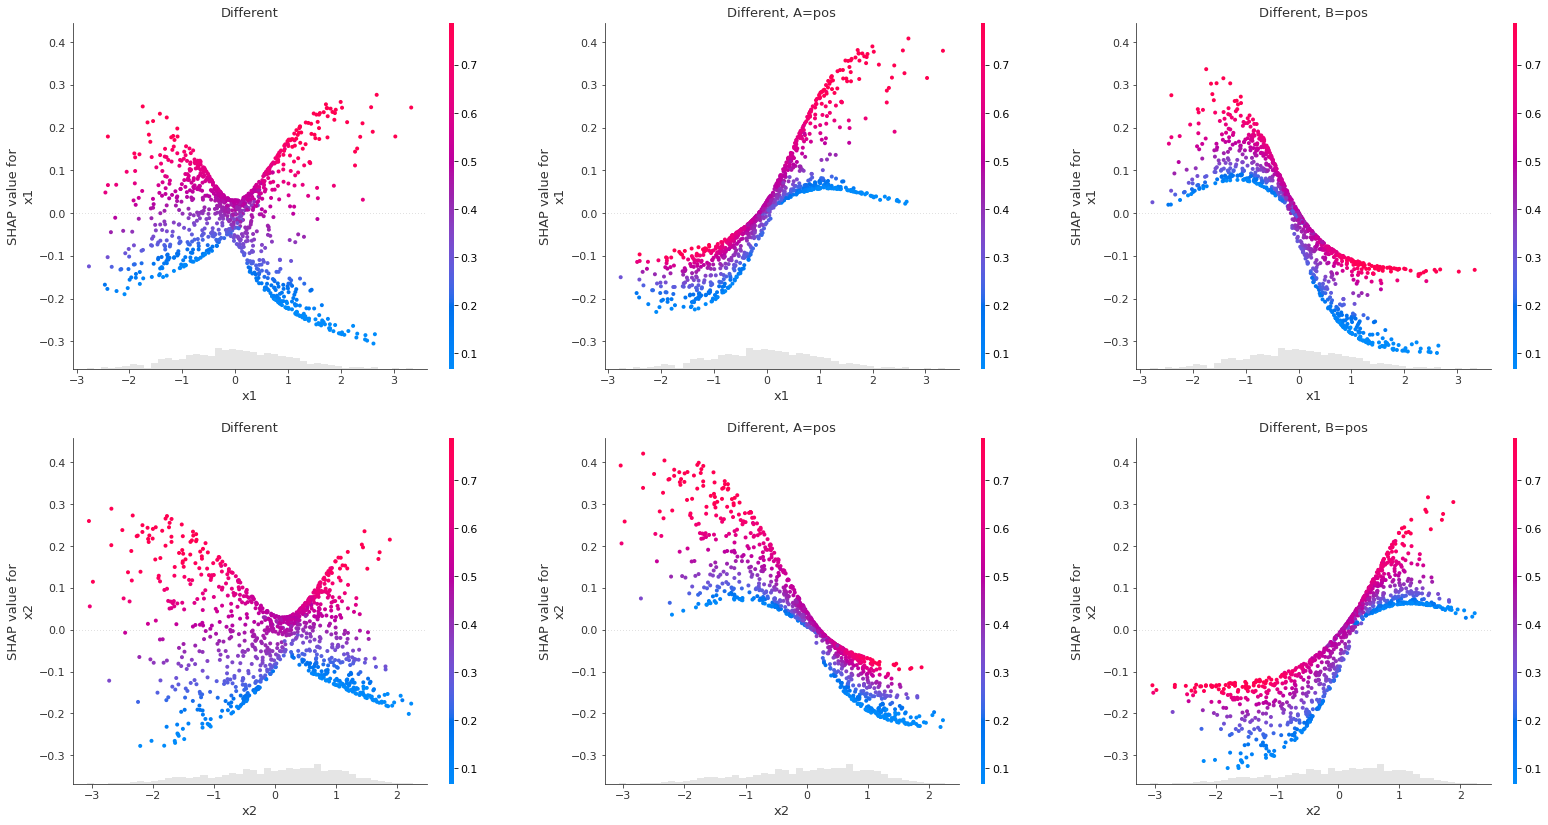

In [12]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=ax1)
    shap.plots.scatter(shap_values_diff[:, feature], title='Different', ax=ax1, color=proba_diff, show=False)
    shap.plots.scatter(shap_values_diff_a_pos[:, feature], title='Different, A=pos', ax=ax2, color=proba_diff, show=False)
    shap.plots.scatter(shap_values_diff_b_pos[:, feature], title='Different, B=pos', ax=ax3, color=proba_diff, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [13]:
idx_diff = indices[pred_a != pred_b]
idx_equal = indices[pred_a == pred_b]
if len(idx_diff) > 500:
    idx_diff = shuffle(idx_diff, random_state=0, n_samples=500)
if len(idx_equal) > 500:
    idx_equal = shuffle(idx_equal, random_state=0, n_samples=500)

In [14]:
order = plot.shap_force(shap_values_diff[idx_diff], 'Different')
plot.shap_force(shap_values_diff_a_pos[idx_diff], 'Different, A=pos', ordering=order)
plot.shap_force(shap_values_diff_b_pos[idx_diff], 'Different, B=pos', ordering=order);

In [15]:
order = plot.shap_force(shap_values_diff[idx_equal], 'Different')
plot.shap_force(shap_values_diff_a_pos[idx_equal], 'Different, A=pos', ordering=order)
plot.shap_force(shap_values_diff_b_pos[idx_equal], 'Different, B=pos', ordering=order);

### Hierarchically Clustered SHAP Values

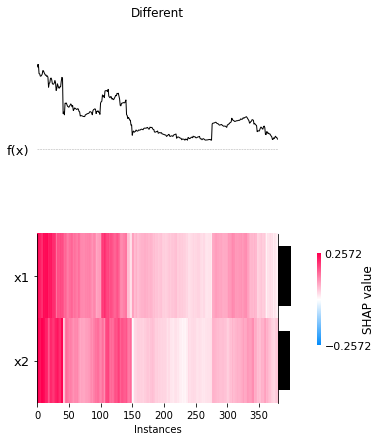

In [16]:
plot.shap_heatmap(shap_values_diff[idx_diff], 'Different', feature_order)

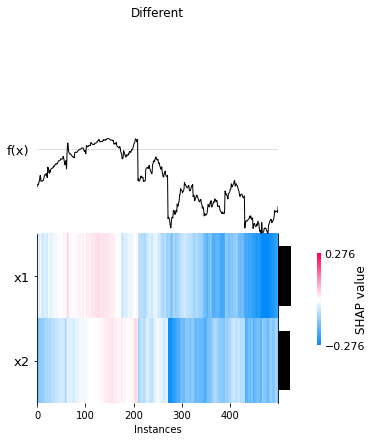

In [17]:
plot.shap_heatmap(shap_values_diff[idx_equal], 'Different', feature_order)

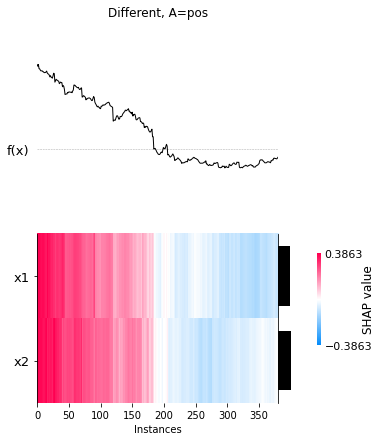

In [18]:
plot.shap_heatmap(shap_values_diff_a_pos[idx_diff], 'Different, A=pos', feature_order)

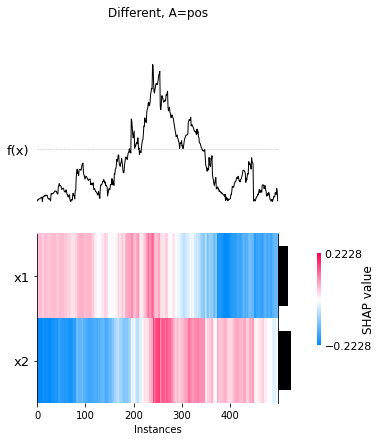

In [19]:
plot.shap_heatmap(shap_values_diff_a_pos[idx_equal], 'Different, A=pos', feature_order)

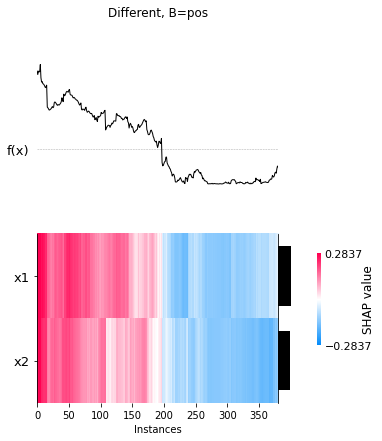

In [20]:
plot.shap_heatmap(shap_values_diff_b_pos[idx_diff], 'Different, B=pos', feature_order)

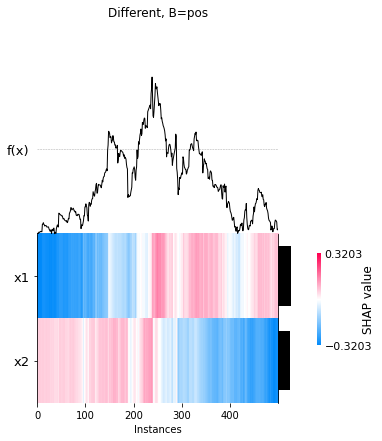

In [21]:
plot.shap_heatmap(shap_values_diff_b_pos[idx_equal], 'Different, B=pos', feature_order)

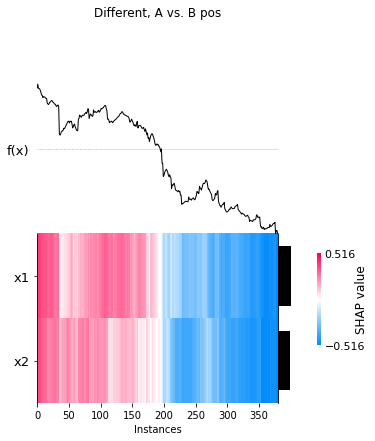

In [22]:
plot.shap_heatmap(shap_values_diff_a_vs_b_pos[idx_diff], 'Different, A vs. B pos', feature_order)

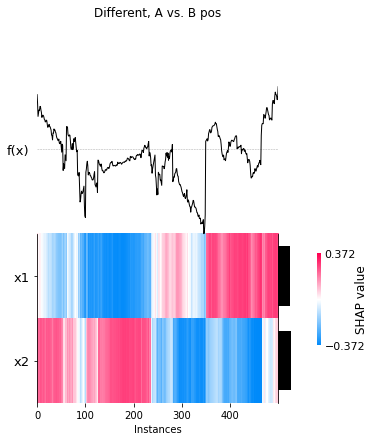

In [23]:
plot.shap_heatmap(shap_values_diff_a_vs_b_pos[idx_equal], 'Different, A vs. B pos', feature_order)